In [7]:
import pickle
import os
from pathlib import Path
import pandas as pd
import sqlite3
import seaborn as sns

In [8]:
PROJECT_ROOT = Path(os.getcwd()).resolve().parents[0]

In [3]:
import pandas as pd
import plotly.express as px
from typing import Union, Callable

def plot_time_evolution(
    df: pd.DataFrame,
    year_col: str,
    month_col: str,
    value_col: str,
    freq: str = "monthly",               # "monthly" or "yearly"
    agg: Union[str, Callable] = "sum",    # e.g. "sum","mean","median","max","min" or a callable
    title: str = None
):
    """
    Plot the evolution of `value_col` over time using (year, month) columns.

    - If `freq="monthly"`: aggregates by year+month then plots monthly values.
    - If `freq="yearly"` : aggregates by year+month first, then aggregates those
      monthly values into yearly values using the same `agg`.

    Parameters
    ----------
    df : DataFrame containing at least [year_col, month_col, value_col]
    year_col, month_col : column names for year and month (month as 1–12)
    value_col : name of the variable to plot
    freq : "monthly" | "yearly"
    agg : aggregation function name or callable (sum/mean/median/max/min/…)
    title : optional plot title

    Returns
    -------
    plotly.graph_objects.Figure
    """
    if freq not in {"monthly", "yearly"}:
        raise ValueError("freq must be 'monthly' or 'yearly'")

    # Ensure integers for year/month and build a first-of-month timestamp
    tmp = df[[year_col, month_col, value_col]].copy()
    tmp[year_col] = tmp[year_col].astype(int)
    tmp[month_col] = tmp[month_col].astype(int)
    tmp["date"] = pd.to_datetime(
        {"year": tmp[year_col], "month": tmp[month_col], "day": 1},
        errors="coerce"
    )

    # 1) Aggregate to monthly (handles duplicates per month safely)
    monthly = (
        tmp.groupby("date", as_index=False)
           .agg(**{value_col: (value_col, agg)})
           .sort_values("date")
    )

    if freq == "monthly":
        fig = px.line(
            monthly, x="date", y=value_col, markers=True,
            title=title or f"{value_col} — monthly ({agg})"
        )
        fig.update_layout(xaxis_title="Month", yaxis_title=value_col)
        return fig

    # 2) Aggregate monthly -> yearly
    yearly = (
        monthly.assign(year=monthly["date"].dt.year)
               .groupby("year", as_index=False)
               .agg(**{value_col: (value_col, agg)})
               .sort_values("year")
    )
    fig = px.line(
        yearly, x="year", y=value_col, markers=True,
        title=title or f"{value_col} — yearly ({agg} of monthly)"
    )
    fig.update_layout(xaxis_title="Year", yaxis_title=value_col)
    return fig


## Old

In [5]:
import pickle

# Replace with your actual file path
file_path = PROJECT_ROOT / "outputs_srm/all_results_Casablanca-Settat_consommation_kwh_gr.pkl"

# Open the pickle file in binary read mode
with open(file_path, "rb") as file:
    data = pickle.load(file)



In [14]:
for el in data[0]["best_model"]["pred_monthly_matrix"]:
    print(el.sum())

1129295116.1654725
1129531884.9130454
1128620546.7117
1128620546.6562543
1129982030.1839204
1129533810.1568573
1128620546.6877244
1128620546.6692195
1128620546.6877239
1128620546.6682265
1031441541.6364876
1121280038.3555932
1121280038.3555932
1121280038.3555934


In [4]:
db_conn = sqlite3.connect(PROJECT_ROOT / "data/ONEE_Distributeurs_consumption.db")

In [5]:
query_dist = f"""
    SELECT
        year as annee,
        month as mois,
        distributeur,
        SUM(consumption_value) as consommation_kwh
    FROM consumption
    WHERE region = 'Casablanca-Settat'
    GROUP BY year, month, distributeur
    ORDER BY year, month, distributeur
"""


In [19]:
df = pd.read_sql_query(query_dist, db_conn)

In [18]:
df["distributeur"].unique()

array(['LYDEC CASABLANCA', 'RADEEJ EL JADIDA'], dtype=object)

In [20]:
temp = df[df["distributeur"] == "RADEEJ EL JADIDA"]
temp = temp.groupby("annee", as_index = False)["consommation_kwh"].sum()

<Axes: xlabel='annee', ylabel='consommation_kwh'>

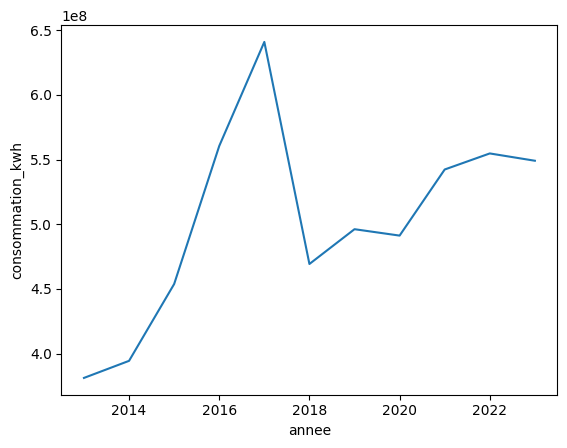

In [21]:
sns.lineplot(x=temp["annee"], y = temp["consommation_kwh"])

# 03/11/2025

In [12]:
# pip install pandas matplotlib numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from typing import Union, Callable, Optional

def export_activity_evolution_to_pdf(
    df: pd.DataFrame,
    pdf_path: str,
    activity_col: str = "activite",
    year_col: str = "annee",
    month_col: str = "mois",
    value_col: str = "consommation",
    client_col: str = "partenaire",
    contract_col: str = "contrat",
    agg: Union[str, Callable] = "sum",
    title_slides: bool = True,
    figsize=(13.5, 7.6),          # ⬅️ bigger default; pass your own to change
    title_prefix: str = "Activité",
    font_main: int = 16,
):
    """
    For each activity:
      - Title slide with activity name + (#unique clients, #unique contracts)
      - Monthly evolution (annual totals annotated, kept inside axes)
      - Yearly evolution (annotated)

    Tip: Pass a custom `figsize` (e.g., (14, 8)) if you want even bigger slides.
    """
    if df.empty:
        raise ValueError("Input dataframe is empty.")

    data = df.copy()
    data[year_col]  = pd.to_numeric(data[year_col],  errors="coerce").astype("Int64")
    data[month_col] = pd.to_numeric(data[month_col], errors="coerce").astype("Int64")
    data = data.dropna(subset=[activity_col, year_col, month_col, value_col])

    def fmt_num(v: float) -> str:
        try:
            return f"{v:,.0f}".replace(",", " ")
        except Exception:
            return str(v)

    with PdfPages(pdf_path) as pdf:
        for act in pd.Index(sorted(data[activity_col].dropna().unique())):
            raw_act = data.loc[data[activity_col] == act].copy()
            if raw_act.empty:
                continue

            n_clients  = (raw_act[client_col].nunique(dropna=True)
                          if client_col in raw_act.columns else None)
            n_contract = (raw_act[contract_col].nunique(dropna=True)
                          if contract_col in raw_act.columns else None)

            monthly = (
                raw_act[[year_col, month_col, value_col]]
                .groupby([year_col, month_col], as_index=False)
                .agg(**{value_col: (value_col, agg)})
                .sort_values([year_col, month_col])
            )
            monthly["date"] = pd.to_datetime(
                dict(year=monthly[year_col].astype(int),
                     month=monthly[month_col].astype(int),
                     day=1),
                errors="coerce"
            )
            monthly = monthly.dropna(subset=["date"])

            yearly = (
                monthly.assign(year=lambda d: d["date"].dt.year)
                       .groupby("year", as_index=False)
                       .agg(**{value_col: (value_col, agg)})
                       .sort_values("year")
            )

            # ---- Title slide
            if title_slides:
                fig = plt.figure(figsize=figsize)
                ax = fig.add_subplot(111)
                ax.axis("off")
                ax.text(0.5, 0.62, f"{title_prefix}: {act}",
                        ha="center", va="center",
                        fontsize=28, fontweight="bold")
                lines = []
                if n_clients  is not None: lines.append(f"Clients uniques : {n_clients}")
                if n_contract is not None: lines.append(f"Contrats uniques : {n_contract}")
                if lines:
                    ax.text(0.5, 0.45, "\n".join(lines),
                            ha="center", va="center", fontsize=font_main)
                pdf.savefig(fig, bbox_inches="tight"); plt.close(fig)

            # ---- Monthly (with safe annual annotations)
            if not monthly.empty:
                fig, ax = plt.subplots(figsize=figsize)
                ax.plot(monthly["date"], monthly[value_col], marker="o")
                ax.set_title(f"{act} — {value_col} (mensuel)", fontsize=font_main)
                ax.set_xlabel("Mois")
                ax.set_ylabel(value_col)
                ax.grid(True, alpha=0.25)

                # pad the top a bit so annotations fit
                ymax = float(np.nanmax(monthly[value_col].to_numpy()))
                if np.isfinite(ymax) and ymax > 0:
                    ax.set_ylim(top=ymax * 1.15)

                if not yearly.empty:
                    # get last month in each year to place labels
                    last_pts = (
                        monthly.assign(year=monthly["date"].dt.year)
                               .sort_values("date")
                               .groupby("year", as_index=False)
                               .tail(1)[["date", value_col]]
                    ).rename(columns={value_col: "last_month_value"})
                    ann = (last_pts.assign(year=last_pts["date"].dt.year)
                                 .merge(yearly, on="year", how="left"))

                    # smart y position: keep text inside axis (near top or just above the last monthly point)
                    y_top = ax.get_ylim()[1]
                    pad   = 0.05 * ymax if np.isfinite(ymax) else 0
                    for _, r in ann.iterrows():
                        # preferred position just above last monthly point
                        y_pref = float(r.get("last_month_value", np.nan)) + pad
                        # clamp near the top if that would go out of range
                        y_plot = min(y_pref, y_top * 0.96)
                        ax.annotate(
                            fmt_num(r[value_col]),  # annual total text
                            xy=(r["date"], y_plot),
                            xytext=(0, 0),
                            textcoords="offset points",
                            ha="center", va="bottom", fontsize=12
                        )

                fig.tight_layout()
                pdf.savefig(fig, bbox_inches="tight"); plt.close(fig)

            # ---- Yearly (annotate each year)
            if not yearly.empty:
                fig, ax = plt.subplots(figsize=figsize)
                ax.plot(yearly["year"], yearly[value_col], marker="o")
                ax.set_title(f"{act} — {value_col} (annuel)", fontsize=font_main)
                ax.set_xlabel("Année")
                ax.set_ylabel(value_col)
                ax.grid(True, alpha=0.25)

                # give a little headroom for labels
                y2max = float(np.nanmax(yearly[value_col].to_numpy()))
                if np.isfinite(y2max) and y2max > 0:
                    ax.set_ylim(top=y2max * 1.10)

                for _, r in yearly.iterrows():
                    ax.annotate(fmt_num(r[value_col]),
                                xy=(r["year"], r[value_col]),
                                xytext=(0, 10),
                                textcoords="offset points",
                                ha="center", va="bottom", fontsize=12)

                fig.tight_layout()
                pdf.savefig(fig, bbox_inches="tight"); plt.close(fig)

    print(f"Saved PDF to {pdf_path}")


In [4]:
df = pd.read_csv(PROJECT_ROOT / "data/cd_data_2013_2023.csv")

In [41]:
df_all = df.groupby(['annee', 'mois']).agg({
            "consommation": 'sum',
            'temperature': 'mean'
        }).reset_index()

In [42]:
df["activite"].unique()

array(['METALLURGIE',
       "FABRICATION D'AUTRES PRODUITS MINERAUX NON METALLIQUES",
       'TRANSPORTS TERESSTRES',
       "PRODUCTION ET DISTTRIBUTION D'ELECTRICITE, DE GAZ ET DE CHALEUR",
       'ADMINISTRATION PUBLIQUE', 'INDUSTRIE DU PAPIER ET DU CARTON',
       "CAPTAGE, TRAITEMENT ET DISTRIBUTION D'EAU",
       'AGRICULTURE, CHASSE, SERVICES ANNEXES',
       'EXTRACTION, EXPLOITATION ET ENRICHISSEMENT DE MINERAIS METTALLIQUES',
       'AUTRES INDUSTRIES EXTRACTIVES',
       'SERVIVES AUXILIAIRES DES TRANSPORTS', 'INDUSTRIE CHIMIQUE',
       "FABRICATION D'EQUIPEMENTS DE RADIO, TELEVISION ET COMMUNICATION",
       'COKEFACTION, RAFFINAGE, INDUSTRIE NUCLEAIRE', 'INDUSTRIE TEXTILE',
       'TRAVAIL DES METAUX', 'INDUSTRIE AUTOMOBILE',
       'BATIMENT ET TRAVAUX PUBLICS', 'industries alimentaires'],
      dtype=object)

In [ ]:
df_activite = df[df["activite"] == "ADMINISTRATION PUBLIQUE"]
df_activite = df_activite.groupby(['annee', 'mois']).agg({
            "consommation": 'sum',
            'temperature': 'mean'
        }).reset_index()

In [59]:
df_activite["partenaire"].unique()

array(['FORCES ARMEES ROYALES'], dtype=object)

In [ ]:
plot_time_evolution(df_activite, "annee", "mois", "consommation")

In [48]:
plot_time_evolution(df_activite, "annee", "mois", "consommation", freq = "yearly", agg = "sum")

# 04/11/2025

In [13]:
def export_contract_evolution_to_pdf(
    df: pd.DataFrame,
    pdf_path: str,
    activity_col: str = "activite",
    year_col: str = "annee",
    month_col: str = "mois",
    value_col: str = "consommation",
    client_col: str = "partenaire",
    contract_col: str = "contrat",
    agg: Union[str, Callable] = "sum",
    title_slides: bool = True,
    figsize=(13.5, 7.6),
    font_main: int = 16,
):
    """
    For each contract:
      - Title slide with contract ID (big title),
        then corresponding partenaire and activite below
      - Monthly and yearly evolution plots (similar to activity version)
    """
    if df.empty:
        raise ValueError("Input dataframe is empty.")

    data = df.copy()
    data[year_col]  = pd.to_numeric(data[year_col],  errors="coerce").astype("Int64")
    data[month_col] = pd.to_numeric(data[month_col], errors="coerce").astype("Int64")
    data = data.dropna(subset=[contract_col, year_col, month_col, value_col])

    def fmt_num(v: float) -> str:
        try:
            return f"{v:,.0f}".replace(",", " ")
        except Exception:
            return str(v)

    with PdfPages(pdf_path) as pdf:
        for contrat in pd.Index(sorted(data[contract_col].dropna().unique())):
            raw_c = data.loc[data[contract_col] == contrat].copy()
            if raw_c.empty:
                continue

            partenaire = raw_c[client_col].dropna().unique()
            activite   = raw_c[activity_col].dropna().unique()

            partenaire_text = partenaire[0] if len(partenaire) == 1 else ", ".join(partenaire[:3]) + ("..." if len(partenaire) > 3 else "")
            activite_text   = activite[0] if len(activite) == 1 else ", ".join(activite[:3]) + ("..." if len(activite) > 3 else "")

            monthly = (
                raw_c[[year_col, month_col, value_col]]
                .groupby([year_col, month_col], as_index=False)
                .agg(**{value_col: (value_col, agg)})
                .sort_values([year_col, month_col])
            )
            monthly["date"] = pd.to_datetime(
                dict(year=monthly[year_col].astype(int),
                     month=monthly[month_col].astype(int),
                     day=1),
                errors="coerce"
            )
            monthly = monthly.dropna(subset=["date"])

            yearly = (
                monthly.assign(year=lambda d: d["date"].dt.year)
                       .groupby("year", as_index=False)
                       .agg(**{value_col: (value_col, agg)})
                       .sort_values("year")
            )

            # ---- Title slide
            if title_slides:
                fig = plt.figure(figsize=figsize)
                ax = fig.add_subplot(111)
                ax.axis("off")
                ax.text(0.5, 0.65, f"Contrat : {contrat}",
                        ha="center", va="center",
                        fontsize=30, fontweight="bold")

                info_lines = []
                if partenaire_text:
                    info_lines.append(f"Partenaire : {partenaire_text}")
                if activite_text:
                    info_lines.append(f"Activité : {activite_text}")

                if info_lines:
                    ax.text(0.5, 0.45, "\n".join(info_lines),
                            ha="center", va="center", fontsize=font_main)
                pdf.savefig(fig, bbox_inches="tight"); plt.close(fig)

            # ---- Monthly evolution
            if not monthly.empty:
                fig, ax = plt.subplots(figsize=figsize)
                ax.plot(monthly["date"], monthly[value_col], marker="o")
                ax.set_title(f"Contrat {contrat} — {value_col} (mensuel)", fontsize=font_main)
                ax.set_xlabel("Mois")
                ax.set_ylabel(value_col)
                ax.grid(True, alpha=0.25)

                ymax = float(np.nanmax(monthly[value_col].to_numpy()))
                if np.isfinite(ymax) and ymax > 0:
                    ax.set_ylim(top=ymax * 1.15)

                if not yearly.empty:
                    last_pts = (
                        monthly.assign(year=monthly["date"].dt.year)
                               .sort_values("date")
                               .groupby("year", as_index=False)
                               .tail(1)[["date", value_col]]
                    ).rename(columns={value_col: "last_month_value"})
                    ann = (last_pts.assign(year=last_pts["date"].dt.year)
                                 .merge(yearly, on="year", how="left"))

                    y_top = ax.get_ylim()[1]
                    pad   = 0.05 * ymax if np.isfinite(ymax) else 0
                    for _, r in ann.iterrows():
                        y_pref = float(r.get("last_month_value", np.nan)) + pad
                        y_plot = min(y_pref, y_top * 0.96)
                        ax.annotate(fmt_num(r[value_col]),
                                    xy=(r["date"], y_plot),
                                    xytext=(0, 0),
                                    textcoords="offset points",
                                    ha="center", va="bottom", fontsize=12)

                fig.tight_layout()
                pdf.savefig(fig, bbox_inches="tight"); plt.close(fig)

            # ---- Yearly evolution
            if not yearly.empty:
                fig, ax = plt.subplots(figsize=figsize)
                ax.plot(yearly["year"], yearly[value_col], marker="o")
                ax.set_title(f"Contrat {contrat} — {value_col} (annuel)", fontsize=font_main)
                ax.set_xlabel("Année")
                ax.set_ylabel(value_col)
                ax.grid(True, alpha=0.25)

                y2max = float(np.nanmax(yearly[value_col].to_numpy()))
                if np.isfinite(y2max) and y2max > 0:
                    ax.set_ylim(top=y2max * 1.10)

                for _, r in yearly.iterrows():
                    ax.annotate(fmt_num(r[value_col]),
                                xy=(r["year"], r[value_col]),
                                xytext=(0, 10),
                                textcoords="offset points",
                                ha="center", va="bottom", fontsize=12)

                fig.tight_layout()
                pdf.savefig(fig, bbox_inches="tight"); plt.close(fig)

    print(f"✅ Saved contract evolution PDF to {pdf_path}")


In [9]:
df = pd.read_csv(PROJECT_ROOT / "data/cd_data_2013_2023.csv")

In [11]:
df.columns

Index(['partenaire', 'contrat', 'activite', 'secteur', 'annee', 'mois',
       'ventes', 'consommation', 'temperature', 'Date d'emménagement',
       'Date de déménagement', 'puissance facturée'],
      dtype='object')

In [12]:
df.drop(columns = ["Date d'emménagement",
       'Date de déménagement', 'puissance facturée'], inplace = True)

In [13]:
mapping = {
    ("ACWA POWER OUARZAZATE I", 5729390): ("ACWA POWER OUARZAZATE II", 6447659),
    ("ACWA POWER OUARZAZATE I", 5731079): ("ACWA POWER OUARZAZATE III", 6457296),
    ("ACWA POWER OUARZAZATE I", 5741477): ("ACWA POWER KHALLADI", 6434280),
    ("ACWA POWER OUARZAZATE I", 6192130): ("ACWA POWER LAAYOUNE", 6457387),
    ("ACWA POWER OUARZAZATE I", 6160312): ("ACWA POWER OUARZAZATE IV", 6457370),
    ("OCP SA", 217176): ("PHOSBOUCRAA", 6500531),
    ("CIMENTS DU MAROC", 217169): ("INDUSAHA", 8192392),
    ("AKKA GOLD MINING", 5331362): ("AKKA GOLD MINING", 9236601)
}

# --- Code to apply the mapping ---
def update_partenaire_contrat(df, mapping):
    """
    Replace (partenaire, contrat) pairs based on a mapping dictionary.
    Prints warnings if any mapping keys were not found in the DataFrame.
    """

    # Track which mappings were applied
    found_keys = set()

    # Iterate through mapping dict and update DataFrame rows
    for (old_part, old_contrat), (new_part, new_contrat) in mapping.items():
        mask = (df["partenaire"] == old_part) & (df["contrat"] == old_contrat)
        if mask.any():
            df.loc[mask, "partenaire"] = new_part
            df.loc[mask, "contrat"] = new_contrat
            found_keys.add((old_part, old_contrat))

    # Print warnings for any unmapped keys
    missing = set(mapping.keys()) - found_keys
    if missing:
        print("⚠️ Warning: The following (partenaire, contrat) pairs were not found in the DataFrame:")
        for key in missing:
            print("   ", key)
    else:
        print("✅ All mappings successfully applied.")

    return df

# Example usage:
df = update_partenaire_contrat(df, mapping)

⚠️ Warning: The following (partenaire, contrat) pairs were not found in the DataFrame:
    ('ACWA POWER OUARZAZATE I', 6192130)
    ('AKKA GOLD MINING', 5331362)
    ('ACWA POWER OUARZAZATE I', 5731079)
    ('ACWA POWER OUARZAZATE I', 5741477)
    ('CIMENTS DU MAROC', 217169)
    ('ACWA POWER OUARZAZATE I', 5729390)
    ('ACWA POWER OUARZAZATE I', 6160312)
    ('OCP SA', 217176)


In [14]:
# Instead of per-activity manual plotting, just call on the *raw* df:
export_contract_evolution_to_pdf(
    df,                           # raw dataframe with all activities
    pdf_path="contrats_evolution.pdf",
    activity_col="activite",
    year_col="annee",
    month_col="mois",
    value_col="consommation",
    client_col="partenaire",
    contract_col="contrat",
    agg="sum",
    title_slides=True
)

✅ Saved contract evolution PDF to contrats_evolution.pdf


In [14]:
df_puis = pd.read_excel(PROJECT_ROOT / "data/raw/Puissance souscrite par Mois.xlsx", sheet_name = "Puissance par Mois") #Nom du site - Contrat

In [15]:
df_puis.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,01.2018,02.2018,03.2018,04.2018,05.2018,...,12.2024,01.2025,02.2025,03.2025,04.2025,05.2025,06.2025,07.2025,08.2025,09.2025
0,Business Partner,Contrat,Date d'emménagement,Date de déménagement,Type de ligne (Poste Horaire),Puis Sous,Puis Sous,Puis Sous,Puis Sous,Puis Sous,...,Puis Sous,Puis Sous,Puis Sous,Puis Sous,Puis Sous,Puis Sous,Puis Sous,Puis Sous,Puis Sous,Puis Sous
1,ACWA POWER KHALLADI,6434280,2019-03-02 00:00:00,9999-12-31 00:00:00,Puis Sous HC -Tarif Opt,0,0,0,0,0,...,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200
2,ACWA POWER KHALLADI,6434280,2019-03-02 00:00:00,9999-12-31 00:00:00,Puis Sous HPL -Tarif Opt,0,0,0,0,0,...,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200
3,ACWA POWER KHALLADI,6434280,2019-03-02 00:00:00,9999-12-31 00:00:00,Puis Sous HP -Tarif Opt,0,0,0,0,0,...,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200
4,ACWA POWER LAAYOUNE,6457387,2019-03-02 00:00:00,9999-12-31 00:00:00,Puis Sous -Tarif Gén,0,0,0,0,0,...,500,500,500,500,500,500,500,500,500,500


In [16]:
cols = list(df_puis.columns)

In [17]:
for j in range(5):
    cols[j] = df_puis.iloc[0, j]

cols[4] = "Type de ligne"

In [18]:
df_puis.columns = cols

In [19]:
df_puis.drop(index=[0], columns = ["Business Partner"], inplace = True)

In [21]:
import pandas as pd
import numpy as np
from typing import List, Optional, Dict

def compute_pf_v3(
    df: pd.DataFrame,
    contrat_col: str = "Contrat",
    type_col: str = "Type de ligne",
    numeric_cols: Optional[List[str]] = None,
    passthrough_cols: Optional[List[str]] = None,
    return_details: bool = True,
) -> pd.DataFrame:
    """
    Compute Pf per 'Contrat' using exact type labels and a forgiving GEN case.
    """
    # ✅ Exact expected labels
    map_clean = {
        "Puis Sous HP -Tarif Opt": "HP",
        "Puis Sous HPL -Tarif Opt": "HPL",
        "Puis Sous HC -Tarif Opt": "HC",
        "Puis Sous HSP -Tarif Sup pointe": "HSP",
        "Puis Sous -Tarif Gén": "GEN",
    }

    # passthrough columns (not transformed)
    if passthrough_cols is None:
        passthrough_cols = [c for c in ["Date d'emménagement", "Date de déménagement"] if c in df.columns]

    # numeric columns to transform
    if numeric_cols is None:
        numeric_cols = [
            c for c in df.select_dtypes(include=[np.number]).columns
            if c not in {contrat_col, type_col} and c not in set(passthrough_cols)
        ]

    work = df.copy()
    work["__TYPE_CANON__"] = work[type_col]

    # Check for unexpected type values
    unknown = sorted(set(work["__TYPE_CANON__"]) - set(map_clean.keys()))
    if unknown:
        raise ValueError(f"Type(s) de ligne inconnus: {unknown}")

    work["__TYPE_CANON__"] = work["__TYPE_CANON__"].map(map_clean)

    def passthrough_vals(g: pd.DataFrame) -> Dict[str, object]:
        vals = {}
        for c in passthrough_cols:
            uniq = g[c].dropna().unique()
            vals[c] = uniq[0] if len(uniq) == 1 else (g[c].iloc[0] if len(uniq) > 1 else np.nan)
        return vals

    def process_group(g: pd.DataFrame) -> pd.Series:
        types = set(g["__TYPE_CANON__"].unique())
        result: Dict[str, object] = {}
        warnings = []

        # Copy passthroughs
        result.update(passthrough_vals(g))
        for c in passthrough_cols:
            if g[c].nunique(dropna=True) > 1:
                warnings.append(f"Valeurs différentes pour '{c}'")

        # --- GEN forgiving case ---
        if "GEN" in types:
            if len(types) > 1:
                print(f"[AVERTISSEMENT] Contrat {g[contrat_col].iloc[0]} : "
                    f"'Puis Sous -Tarif Gén' trouvé avec d'autres types — les autres seront ignorés dans le calcul (moyenne utilisée).")
                warnings.append("'Tarif Gén' prioritaire — moyenne utilisée sur les valeurs présentes")
            # Keep only rows with GEN for clarity in the tariff label, but compute on all numeric rows
            tarif = "Tarif gén"
            for col in numeric_cols:
                mean_val = g[col].mean(skipna=True)
                result[f"Pf__{col}"] = float(mean_val) if pd.notna(mean_val) else np.nan
            if return_details:
                result["tarif"] = tarif
                result["warnings"] = "; ".join(warnings) if warnings else ""
            return pd.Series(result)

        # --- Optionnel or Super Pointe ---
        if types == {"HP", "HPL", "HC"}:
            tarif = "Tarif optionnel"
            mapping = ["HP", "HPL", "HC"]
            weights = np.array([0.4, 0.2, 0.4])
        elif types == {"HSP", "HP", "HPL", "HC"}:
            tarif = "Tarif super pointe"
            mapping = ["HSP", "HP", "HPL", "HC"]
            weights = np.array([0.2, 0.2, 0.2, 0.4])
        else:
            raise ValueError(f"[{g[contrat_col].iloc[0]}] Combinaison de types invalide: {sorted(types)}")

        pivot = g.set_index("__TYPE_CANON__")

        for col in numeric_cols:
            values = [pivot.loc[t, col] for t in mapping]
            if any(pd.isna(values)):
                warnings.append(f"{col}: valeurs manquantes pour {mapping}")
                pf = np.nan
            else:
                if not all(values[i] <= values[i + 1] for i in range(len(values) - 1)):
                    warnings.append(f"{col}: non monotone {values}")
                pf = float(np.dot(weights, np.array(values, dtype=float)))
            result[f"Pf__{col}"] = pf

        if return_details:
            result["tarif"] = tarif
            result["warnings"] = "; ".join(warnings) if warnings else ""
        return pd.Series(result)

    out = work.groupby(contrat_col, as_index=True, sort=False).apply(process_group)
    out.index.name = contrat_col
    return out.reset_index()


In [22]:
res = compute_pf_v3(df_puis, numeric_cols=df_puis.columns[4:])

[AVERTISSEMENT] Contrat 5741477 : 'Puis Sous -Tarif Gén' trouvé avec d'autres types — les autres seront ignorés dans le calcul (moyenne utilisée).
[AVERTISSEMENT] Contrat 7875826 : 'Puis Sous -Tarif Gén' trouvé avec d'autres types — les autres seront ignorés dans le calcul (moyenne utilisée).
[AVERTISSEMENT] Contrat 891223 : 'Puis Sous -Tarif Gén' trouvé avec d'autres types — les autres seront ignorés dans le calcul (moyenne utilisée).
[AVERTISSEMENT] Contrat 217252 : 'Puis Sous -Tarif Gén' trouvé avec d'autres types — les autres seront ignorés dans le calcul (moyenne utilisée).
[AVERTISSEMENT] Contrat 6955110 : 'Puis Sous -Tarif Gén' trouvé avec d'autres types — les autres seront ignorés dans le calcul (moyenne utilisée).
[AVERTISSEMENT] Contrat 8619832 : 'Puis Sous -Tarif Gén' trouvé avec d'autres types — les autres seront ignorés dans le calcul (moyenne utilisée).
[AVERTISSEMENT] Contrat 217229 : 'Puis Sous -Tarif Gén' trouvé avec d'autres types — les autres seront ignorés dans le c

C:\Users\Soufiane.AITELAOUAD\AppData\Local\Temp\ipykernel_9940\3791759647.py:110: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = work.groupby(contrat_col, as_index=True, sort=False).apply(process_group)


In [23]:
res.rename(columns = {"Contrat":"contrat"}, inplace = True)

In [24]:
res.head()

,contrat,Date d'emménagement,Date de déménagement,Pf__01.2018,Pf__02.2018,Pf__03.2018,Pf__04.2018,Pf__05.2018,Pf__06.2018,Pf__07.2018,...,Pf__02.2025,Pf__03.2025,Pf__04.2025,Pf__05.2025,Pf__06.2025,Pf__07.2025,Pf__08.2025,Pf__09.2025,tarif,warnings
0,6434280,2019-03-02,9999-12-31 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,Tarif optionnel,
1,6457387,2019-03-02,9999-12-31 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,Tarif gén,
2,5022460,2015-09-06,9999-12-31 00:00:00,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0,...,7600.0,7600.0,7600.0,7600.0,7600.0,7600.0,7600.0,7600.0,Tarif gén,
3,5729390,2017-09-01,2019-03-01 00:00:00,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tarif gén,
4,5731079,2017-09-01,2019-03-01 00:00:00,6000.0,6000.0,6000.0,6000.0,6000.0,15000.0,15000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tarif gén,


In [25]:
import re
import pandas as pd

id_cols = ['contrat', "Date d'emménagement", "Date de déménagement"]

val_cols = [c for c in res.columns if re.match(r'^.+__\d{2}\.\d{4}$', str(c))]

long = res.melt(id_vars=id_cols, value_vars=val_cols,
               var_name='key', value_name='value')

parts = long['key'].str.extract(r'^(?P<metric>.+?)__(?P<Month>\d{2})\.(?P<Year>\d{4})')
long = pd.concat([long.drop(columns='key'), parts], axis=1)
long['Month'] = long['Month'].astype(int)
long['Year'] = long['Year'].astype(int)
long['metric'] = long['metric'].str.strip()

wide = (long.pivot_table(index=id_cols+['Year','Month'],
                         columns='metric', values='value', aggfunc='first')
             .reset_index())

wide = wide.rename(columns={'Pf':'puissance facturée'})

In [26]:
wide.rename(columns = {"Month": "mois", "Year": "annee"}, inplace = True)

In [27]:
wide.columns

Index(['contrat', 'Date d'emménagement', 'Date de déménagement', 'annee',
       'mois', 'puissance facturée'],
      dtype='object', name='metric')

In [28]:
df.columns

Index(['partenaire', 'contrat', 'activite', 'secteur', 'annee', 'mois',
       'ventes', 'consommation', 'temperature'],
      dtype='object')

In [29]:
wide["contrat"] = wide["contrat"].astype(int)

In [30]:
wide

metric,contrat,Date d'emménagement,Date de déménagement,annee,mois,puissance facturée
0,217004,2007-04-01,2022-11-24 00:00:00,2018,1,250.0
1,217004,2007-04-01,2022-11-24 00:00:00,2018,2,250.0
2,217004,2007-04-01,2022-11-24 00:00:00,2018,3,250.0
3,217004,2007-04-01,2022-11-24 00:00:00,2018,4,250.0
4,217004,2007-04-01,2022-11-24 00:00:00,2018,5,250.0
...,...,...,...,...,...,...
15340,9549388,2025-08-23,9999-12-31 00:00:00,2025,5,0.0
15341,9549388,2025-08-23,9999-12-31 00:00:00,2025,6,0.0
15342,9549388,2025-08-23,9999-12-31 00:00:00,2025,7,0.0
15343,9549388,2025-08-23,9999-12-31 00:00:00,2025,8,2000.0


In [ ]:
new_mapping = {
    5729390: 6447659,
    5731079: 6457296,
    5741477: 6434280,
    6192130: 6457387,
    6160312: 6457370,
    217176: 6500531,
    217169: 8192392,
    5331362: 9236601
}

In [33]:
wide.replace(new_mapping, inplace=True)

In [ ]:
wide_[wide_["contrat"] == 8192392]

metric,contrat,Date d'emménagement,Date de déménagement,annee,mois,puissance facturée
13113,8303294,2021-12-18,9999-12-31 00:00:00,2018,1,0.0
13114,8303294,2021-12-18,9999-12-31 00:00:00,2018,2,0.0
13115,8303294,2021-12-18,9999-12-31 00:00:00,2018,3,0.0
13116,8303294,2021-12-18,9999-12-31 00:00:00,2018,4,0.0
13117,8303294,2021-12-18,9999-12-31 00:00:00,2018,5,0.0
...,...,...,...,...,...,...
13201,8303294,2021-12-18,9999-12-31 00:00:00,2025,5,79600.0
13202,8303294,2021-12-18,9999-12-31 00:00:00,2025,6,79600.0
13203,8303294,2021-12-18,9999-12-31 00:00:00,2025,7,79600.0
13204,8303294,2021-12-18,9999-12-31 00:00:00,2025,8,79600.0


In [56]:
wide[wide["contrat"] == 8303294]

,contrat,Date d'emménagement,Date de déménagement,annee,mois,puissance facturée
13113,8303294,2021-12-18,9999-12-31 00:00:00,2018,1,0.0
13114,8303294,2021-12-18,9999-12-31 00:00:00,2018,2,0.0
13115,8303294,2021-12-18,9999-12-31 00:00:00,2018,3,0.0
13116,8303294,2021-12-18,9999-12-31 00:00:00,2018,4,0.0
13117,8303294,2021-12-18,9999-12-31 00:00:00,2018,5,0.0
...,...,...,...,...,...,...
13201,8303294,2021-12-18,9999-12-31 00:00:00,2025,5,79600.0
13202,8303294,2021-12-18,9999-12-31 00:00:00,2025,6,79600.0
13203,8303294,2021-12-18,9999-12-31 00:00:00,2025,7,79600.0
13204,8303294,2021-12-18,9999-12-31 00:00:00,2025,8,79600.0


In [49]:
wide_ = wide.copy()

In [47]:
from datetime import datetime

def safe_parse_date(x):
    """Try to parse a date string safely (return None if it fails)."""
    if pd.isna(x):
        return None
    x = str(x).strip()
    # try common formats — you can extend if needed
    for fmt in ("%Y-%m-%d", "%d.%m.%Y", "%d/%m/%Y", "%Y/%m/%d", "%Y-%m-%d %H:%M:%S"):
        try:
            return datetime.strptime(x, fmt)
        except ValueError:
            continue
    return None  # could not parse

In [48]:
safe_parse_date("9999-12-31 00:00:00")

datetime.datetime(9999, 12, 31, 0, 0)

In [50]:
# --- Your existing code ---
contracts_to_fix = list(new_mapping.values())
mask = wide["contrat"].isin(contracts_to_fix)
subset = wide[mask]

# --- Compute min/max per contract manually ---
date_ranges = []
for contrat, group in subset.groupby("contrat"):
    move_in_dates = [safe_parse_date(x) for x in group["Date d'emménagement"]]
    move_out_dates = [safe_parse_date(x) for x in group["Date de déménagement"]]

    # Filter out None values for comparison
    valid_in = [d for d in move_in_dates if d is not None]
    valid_out = [d for d in move_out_dates if d is not None]

    min_in = min(valid_in) if valid_in else None
    max_out = max(valid_out) if valid_out else None

    date_ranges.append({
        "contrat": contrat,
        "Date d'emménagement": min_in,
        "Date de déménagement": max_out
    })

date_ranges = pd.DataFrame(date_ranges)

# --- Merge back to main dataframe ---
wide = wide.merge(date_ranges, on="contrat", how="left", suffixes=("", "_fixed"))

# --- Replace with fixed values only for those contracts ---
wide.loc[mask, "Date d'emménagement"] = wide.loc[mask, "Date d'emménagement_fixed"]
wide.loc[mask, "Date de déménagement"] = wide.loc[mask, "Date de déménagement_fixed"]

# --- Drop helper columns ---
wide.drop(columns=["Date d'emménagement_fixed", "Date de déménagement_fixed"], inplace=True)

In [98]:
df = df.groupby(['partenaire', 'contrat', 'activite', 'secteur', 'annee', 'mois'], as_index = False).agg({"ventes":"sum", "consommation":"sum", "temperature":"mean"})

In [104]:
wide.duplicated(subset=["contrat", "annee", "mois", "Date d'emménagement", 'Date de déménagement']).sum()


np.int64(744)

In [107]:
wide = wide.groupby(["contrat", "annee", "mois", "Date d'emménagement", 'Date de déménagement'], as_index = False).agg({"puissance facturée":"sum"})

In [108]:
len(df)

21384

In [109]:
merged_df = df.merge(wide, how = "left", on = ["contrat", "annee", "mois"])

In [111]:
merged_df.to_csv(PROJECT_ROOT / "data/cd_data_2013_2023.csv", index = False)

In [112]:
import sqlite3

In [113]:
db_conn = sqlite3.connect(PROJECT_ROOT / "data/cd_database_2013_2023.db")

In [114]:
merged_df.to_sql("cd", db_conn, if_exists="replace", index=False)

21384